# Creating an numba-compatible sorted array intersection algorithm
In order to apply just in time compilation with numba to a function, all functions that are called in that funcion must also be compatible with numba.

`sortednp.intersect` is one example of a non-compatible function which is used in the core of the greedysearch algorithm that we aim to convert to be numba-compatible. This notebook aims to propose and test a numba-compatible (specifically nopython mode) algoritm with performance as close to `sortednp.intersect` as possible. 

In [65]:
import sortednp as snp
import numpy as np
from numba import njit
from numba.typed import List

@njit
def intersect_sorted_array(A, B):
  """
  Returns the sorted intersection of A and B
  - Assumes A and B are sorted
  - Assumes A and B each have no duplicates
  """
  i = 0
  j = 0
  intersection = List()

  while i < len(A) and j < len(B):
      if A[i] == B[j]:
          intersection.append(A[i])
          i += 1
          j += 1
      elif A[i] < B[j]:
          i += 1
      else:
          j += 1
  return intersection

def snp_intersect(A, B):
  return snp.intersect(A, B)

In [ ]:
# from timeit import repeat, timeit
from math import floor, log, log10, sqrt
import timeit

from matplotlib import test

ns_to_plot = range(0, 100000, 10000)
densities_to_plot = [2/x for x in range(2, 12, 1)][::-1]

# Took 30min for LOOPS_PER_RUN=200, RUNS_PER_REPEAT=7, NUM_REPEATS=21
LOOPS_PER_RUN=100
NUM_REPEATS = 11
RUNS_PER_REPEAT = 5
BASE_N = 90_000
BASE_DENSITY = 1/3

benchmark_configs = [
  {
    'name': 'benchmarks_balanced',
    'display': {
      'title': 'Array A: n elements, Array B: n elements',
      'xlabel': '$n$ (density = 1/3)'
    },
    'iterator': ns_to_plot,
    'config': {
      'n': '$i',
      'm': '$i',
      'density': BASE_DENSITY
    }
  },
  {
    'name': 'benchmarks_small_m',
    'display': {
      'title': 'Array A: 999 elements, Array B: n elements',
      'xlabel': '$n$ (density = 1/3)'
    },
    'iterator': ns_to_plot,
    'config': {
      'n': '$i',
      'm': 999,
      'density': BASE_DENSITY
    }
  },
  {
    'name': 'benchmarks_large_m',
    'display': {
      'title': 'Array A: 100,000 elements, Array B: n elements',
      'xlabel': '$n$ (density = 1/3)'
    },
    'iterator': ns_to_plot,
    'config': {
      'n': '$i',
      'm': 100_000,
      'density': BASE_DENSITY
    }
  },
  {
    'name': 'benchmarks_density',
    'display': {
      'title': 'Array A: n elements, Array B: n elements',
      'xlabel': 'density (n=90,000)'
    },
    'iterator': densities_to_plot,
    'config': {
      'n': BASE_N,
      'm': BASE_N,
      'density': '$i'
    }
  }
]

benchmark_results = {}

RNG = np.random.default_rng(0)

def generate_test_data(number_to_generate, density):
  return np.sort(RNG.choice(number_to_generate*round(1/density), number_to_generate, replace=False))

# Run all functions first to eliminate the effect of compilation
test_A = generate_test_data(100, BASE_DENSITY)
test_B = generate_test_data(100, BASE_DENSITY)
intersect_sorted_array(test_A, test_B)
snp_intersect(test_A, test_B)

for benchmark in benchmark_configs:
  print(benchmark['name'])
  benchmark_results[benchmark['name']] = {
    'intersect_sorted_array': {},
    'snp_intersect': {}
  }
  for i in benchmark['iterator']:
    for method in ['intersect_sorted_array', 'snp_intersect']:
      print(f'i={i}, method={method}:')
      n = i if benchmark['config']['n'] == '$i' else benchmark['config']['n']
      m = i if benchmark['config']['m'] == '$i' else benchmark['config']['m']
      density = i if benchmark['config']['density'] == '$i' else benchmark['config']['density']
      timeresults = []
      for repeat in range(NUM_REPEATS):
        test_A = generate_test_data(n, density)
        test_B = generate_test_data(m, density)
        timeresults.append(min(timeit.repeat(f'{method}(test_A, test_B)', repeat=RUNS_PER_REPEAT, number=LOOPS_PER_RUN, globals=globals())))
      benchmark_results[benchmark['name']][method][i] = timeresults

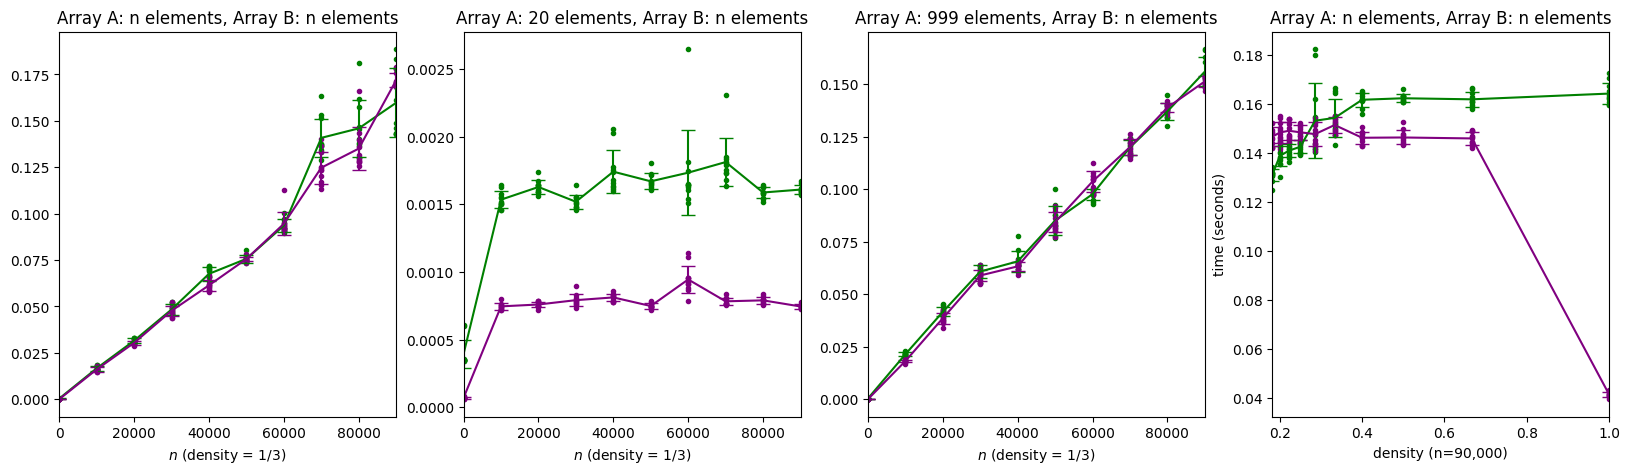

In [143]:
from statistics import mean, stdev
from matplotlib.markers import MarkerStyle
import matplotlib.pyplot as plt
from numpy import average
label_to_colors = {
  'intersect_sorted_array': 'green',
  'snp_intersect': 'purple'
}
plt.subplots(1, 4, figsize=(20, 5))

plt.ylabel('time (seconds)')
for i, benchmark in enumerate(benchmark_configs):
  plt.subplot(1, 4, i+1)
  plt.xlim(benchmark['iterator'][0], benchmark['iterator'][-1])
  plt.title(benchmark['display']['title'])
  plt.xlabel(benchmark['display']['xlabel'])
  for label, time_result in benchmark_results[benchmark['name']].items():
    for i in benchmark['iterator']:
      plt.scatter([i]*NUM_REPEATS, time_result[i], c=label_to_colors[label], marker='.')
    plt.errorbar(benchmark['iterator'], [mean(time_result[i]) for i in benchmark['iterator']], yerr=[stdev(time_result[i]) for i in benchmark['iterator']], marker='', capsize=5.0, label=label, c=label_to_colors[label])

plt.show()

For the following, assume we're intersecting an array with n elements and an array with m elements

I looked into the implementation of sortednp.intersect and discovered it does the following:

iterates over the smaller array, and for each item:
- Search the larger list for it

Therefore theoretically we'd expect it to take:
   loop       search each loop
   v          v
O(min(n,m) * log(max(n, m)))

When we fix m to be less than n (i.e. 20), we would then expect O(log(n)).
In practice (by looking at the second graph above), we find this to be inconclusive. It's possible that it is O(log(n)), but equally possible that the time is constant.


If we fix m to be more then n (i.e. 100000) we would expect the running time to be O(n)
Looking at the third graph above, this looks likely.

Final note:
- There appears to be a disparity between the two algorithms when it comes to the density of the numbers (i.e a density of 1/2 and m=20 means that the 20 numbers are spread between 0 and 40)